In [ ]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax.experimental.ode import odeint
from jax import value_and_grad
from jax.experimental import optimizers
from jax import jit, vmap

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

import sys, getopt

# general 
INFTY = 100
integration_pts = 400001

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [ ]:
@jit
def f_FD(eps,f_params): # (mu, beta)
    mu = f_params[0]
    beta = f_params[1]
    
    return (1 + jnp.exp(beta*(eps-mu)))**-1

@jit
def T2(eps,T2_params): # T2_params: [gamma_L, gamma_R, eps_L, eps_R, omega] (reasonably, [0.05,0.05,4,4,10])

    gamma_L = T2_params[0]
    gamma_R = T2_params[1]
    eps_L = T2_params[2]
    eps_R = T2_params[3]
    omega = T2_params[4]
    a = eps - eps_L
    b = gamma_L/2
    c = eps - eps_R
    d = gamma_R/2

    return (((gamma_L)*(gamma_R)*(omega**2))/(((a*c - b*d - (omega**2))**2) + ((a*d + b*c)**2))) 

In [ ]:
v_f_FD = vmap(f_FD,(0,None))
# v_T = vmap(T,(0,None))
v_T2 = vmap(T2,(0,None)) 

In [ ]:
gamma_L = 0.05
gamma_R = 0.05

eps_L = 0.2
eps_R = 0.

omega = 0.05

H  = jnp.zeros((2,2))
gaL = jnp.zeros((2,2))
gaR = jnp.zeros((2,2))

In [ ]:
gaL = gaL.at[0,0].set(gamma_L)
gaR = gaR.at[1,1].set(gamma_R)

# gaL[0][0] = gamma_L
# gaR[1][1] = gamma_R

print(gaL,"\n\n",gaR)
print(gaL.shape)

gaL_prime = jnp.reshape(gaL,(1,2,2))
print("\n",gaL_prime)

z = jnp.repeat(gaL_prime, 5, axis=0)
print("\nLook below:\n","\n",z)
print(z.shape)


[[0.05 0.  ]
 [0.   0.  ]] 

 [[0.   0.  ]
 [0.   0.05]]
(2, 2)

 [[[0.05 0.  ]
  [0.   0.  ]]]

Look below:
 
 [[[0.05 0.  ]
  [0.   0.  ]]

 [[0.05 0.  ]
  [0.   0.  ]]

 [[0.05 0.  ]
  [0.   0.  ]]

 [[0.05 0.  ]
  [0.   0.  ]]

 [[0.05 0.  ]
  [0.   0.  ]]]
(5, 2, 2)


In [ ]:
H = H.at[0,0].set(eps_L)
H = H.at[1,1].set(eps_R)
H = H.at[0,1].set(omega)
H = H.at[1,0].set(omega)

# H[0][0] = eps_L
# H[1][1] = eps_R
# H[0][1] = omega
# H[1][0] = omega

print(H)

(w,v) = jnp.linalg.eigh(H)

print("\nEigenvalues are:\n\n",w)
print("\nEigenvectors are:\n\n",v)

[[0.2  0.05]
 [0.05 0.  ]]

Eigenvalues are:

 [-0.0118034  0.2118034]

Eigenvectors are:

 [[ 0.22975292 -0.97324899]
 [-0.97324899 -0.22975292]]


In [ ]:
X = jnp.zeros((2,2))

X = X.at[0,0].set(w[0])
X = X.at[1,1].set(w[1])
X = X.at[0,1].set(0.)
X = X.at[1,0].set(0.)

V1 = jnp.zeros((2,2))
V2 = jnp.zeros((2,2))

V1 = v
V2 = jnp.transpose(jnp.conjugate(V1)) 

print(X,"\n\n",V1,"\n\n",V2) 

tilda = jnp.matmul(X,V2)
print("\nTadaaa:\n\n",jnp.matmul(V1,tilda))

[[-0.0118034  0.       ]
 [ 0.         0.2118034]] 

 [[ 0.22975292 -0.97324899]
 [-0.97324899 -0.22975292]] 

 [[ 0.22975292 -0.97324899]
 [-0.97324899 -0.22975292]]

Tadaaa:

 [[2.00000000e-01 5.00000000e-02]
 [5.00000000e-02 6.69361722e-20]]


In [ ]:
zz = jnp.reshape(H,(1,2,2))
zz = jnp.repeat(zz, 5, axis=0)

print("\n",zz)

tt = jnp.linalg.inv(H)
tt1 = np.matrix(tt).H
tt2 = jnp.asarray(tt1)
print("\nOver here:\n\n",tt1,type(tt1))
print("\n",tt2,type(tt2))


 [[[0.    0.005]
  [0.005 0.   ]]

 [[0.    0.005]
  [0.005 0.   ]]

 [[0.    0.005]
  [0.005 0.   ]]

 [[0.    0.005]
  [0.005 0.   ]]

 [[0.    0.005]
  [0.005 0.   ]]]

Over here:

 [[  0. 200.]
 [200.   0.]] <class 'numpy.matrix'>

 [[  0. 200.]
 [200.   0.]] <class 'jaxlib.xla_extension.DeviceArray'>


In [ ]:
print(jnp.matmul(gaL,H))

see = jnp.matmul(z,zz)
print("\nSee the magic now:\n\n",see)

# see.at[]

[[0.      0.00025]
 [0.      0.     ]]

See the magic now:

 [[[0.      0.00025]
  [0.      0.     ]]

 [[0.      0.00025]
  [0.      0.     ]]

 [[0.      0.00025]
  [0.      0.     ]]

 [[0.      0.00025]
  [0.      0.     ]]

 [[0.      0.00025]
  [0.      0.     ]]]


In [ ]:
# Retarded and advanced Green's functions 
def green (eps, input_params):  # input_params = [H, gaL, gaR, mode] and "retarded" by default
    H_s = input_params[0]
    Gamma_L = input_params[1]
    Gamma_R = input_params[2]
    mode = input_params[3]

    Hamiltonian = (eps*(jnp.identity(2))) - H_s  # Hamiltonian = e*I - H; is 2x2 matrix
    NSelf = 0.5j*(Gamma_L + Gamma_R) # Negative of self energy

    # return: resultant = (Hamiltonian + NSelf)^(-1)
    res = jnp.linalg.inv(Hamiltonian + NSelf)

    if (mode == "r"): # retarded green's function
        return res
    elif (mode == "a"): # advanced green's function
        res_prime = jnp.transpose(jnp.conjugate(res)) 
        return res_prime # Hermitian conjugate of Retarded Green's function

v_Green = vmap(green, (0, None))

In [ ]:
my_input = [H, gaL, gaR, "r"] 

G1 = green(1., my_input)
# G2 = green(0.6, my_input, mode="r")
# G3 = green(1., my_input, mode="a")

print(G1)
# # print(G2)
# # print(G3)

# zz = np.trace(G1)
# print("\n\n")
# print("\n",type(zz))

# zzz = np.trace(np.matmul(gaL,G1))
# print("\n",zzz)

test_axis = jnp.linspace(-1.,1.,8) 
zzzz = v_Green(test_axis, my_input)

print("\n","Vectorised green's function is:\n\n",zzzz)

print("\n",jnp.shape(zzzz))

first = zzzz.at[:,1,1].get()
print(first)
print("\n\n",5*first)



[[0.9994003 -0.02498626j 0.00499076-0.0002497j ]
 [0.00499076-0.0002497j  0.9994003 -0.02498626j]]

 Vectorised green's function is:

 [[[-9.99400297e-01-2.49862559e-02j  4.99075898e-03+2.49700254e-04j]
  [ 4.99075898e-03+2.49700254e-04j -9.99400297e-01-2.49862559e-02j]]

 [[-1.39835520e+00-4.89472227e-02j  9.76453277e-03+6.84389206e-04j]
  [ 9.76453277e-03+6.84389206e-04j -1.39835520e+00-4.89472227e-02j]]

 [[-2.32573165e+00-1.35704491e-01j  2.69494784e-02+3.15527197e-03j]
  [ 2.69494784e-02+3.15527197e-03j -2.32573165e+00-1.35704491e-01j]]

 [[-6.79911487e+00-1.19267697e+00j  2.23809702e-01+8.09103916e-02j]
  [ 2.23809702e-01+8.09103916e-02j -6.79911487e+00-1.19267697e+00j]]

 [[ 6.79911487e+00-1.19267697e+00j  2.23809702e-01-8.09103916e-02j]
  [ 2.23809702e-01-8.09103916e-02j  6.79911487e+00-1.19267697e+00j]]

 [[ 2.32573165e+00-1.35704491e-01j  2.69494784e-02-3.15527197e-03j]
  [ 2.69494784e-02-3.15527197e-03j  2.32573165e+00-1.35704491e-01j]]

 [[ 1.39835520e+00-4.89472227e-02j  9

In [ ]:
x, y = 1, 2
y

2

In [ ]:
@jit
def ro (params2, element): # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_L, eps_R, omega)
    # "element" is the tuple input for the matrix element
    # "element" must be one of these: [(0,0),(0,1),(1,0),(1,1)]
    e_axis = jnp.linspace(-INFTY, INFTY, integration_pts) # energy axis

    # fetching parameters
    eps_L = params2[6]
    eps_R = params2[7]
    omega = params2[8]
    gamma_L = params2[2]
    gamma_R = params2[3]

    f_params_L = (params2[0], params2[4])
    f_params_R = (params2[1], params2[5])
    fL = f_FD(e_axis,f_params_L) # fermi-dirac for the left bath
    fR = f_FD(e_axis,f_params_R) # # fermi-dirac for the right bath
    
    # Building-up the Hamiltonian
    H  = jnp.zeros((2,2))
    H = H.at[0,0].set(eps_L)
    H = H.at[1,1].set(eps_R)
    H = H.at[0,1].set(omega)
    H = H.at[1,0].set(omega)

    # Gamma matrices
    gaL = jnp.zeros((2,2))
    gaL = gaL.at[0,0].set(gamma_L)
    gaL_prime = jnp.reshape(gaL,(1,2,2)) 
    gaL_prime = jnp.repeat(gaL_prime, integration_pts, axis=0) 
    # gaL_prime = Vectorized gamma_L

    gaR = jnp.zeros((2,2))
    gaR = gaR.at[1,1].set(gamma_R)
    gaR_prime = jnp.reshape(gaR,(1,2,2)) 
    gaR_prime = jnp.repeat(gaR_prime, integration_pts, axis=0) 
    # gaR_prime = Vectorized gamma_R

    # Green's functions
    G_params_r = [H, gaL, gaR, "r"] # retarded
    v_green_r = v_Green(e_axis, G_params_r)

    G_params_a = [H, gaL, gaR, "a"] # advanced
    v_green_a = v_Green(e_axis, G_params_a)

    # Integrand terms
    temp_L = jnp.matmul(gaL_prime,v_green_a) 
    box_L = jnp.matmul(v_green_r,temp_L)

    temp_R = jnp.matmul(gaR_prime,v_green_a) 
    box_R = jnp.matmul(v_green_r,temp_R)

    # Yanking the (i,j)th element from the vectorized boxes
    i, j = element[0], element[1]
    terms_L = box_L.at[:,i,j].get() # shape = (integration_pts,)
    terms_R = box_R.at[:,i,j].get() # # shape = (integration_pts,)

    res = jnp.sum(
        ((terms_L)*(fL)) + ((terms_R)*(fR))
    )*((e_axis[1]-e_axis[0])/(2.*jnp.pi))

    return res

In [ ]:
@jit
def eigenenergy (full_ro, H_s):
    (w,v) = jnp.linalg.eigh(H_s) # Fetching the eigenfunctions and eigenvalues

    V1 = jnp.zeros((2,2)) # is V
    V2 = jnp.zeros((2,2)) # is V-dagger

    V1 = v
    V2 = jnp.transpose(jnp.conjugate(V1)) # Hermitian conjugate of V1

    tilda = jnp.matmul(full_ro,V1)
    res = jnp.matmul(V2,tilda) 

    return res 

In [ ]:
@jit
def j_c_pow4_2(params2): # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_L, eps_R, omega)
    e_axis = jnp.linspace(-INFTY, INFTY, integration_pts)
    f_params_L = (params2[0], params2[4])
    f_params_R = (params2[1], params2[5])
    T2_params = (params2[2], params2[3], params2[6], params2[7], params2[8]) 

    T2 = v_T2(e_axis,T2_params)
    fL = f_FD(e_axis,f_params_L)
    fR = f_FD(e_axis,f_params_R) 

    A = fL - fR
    B = fL + fR - 2*fL*fR

    terms = T2*B - 3*(T2**2)*(B**2) - 4*(T2**2)*(A**2) + \
            12*(T2**3)*((A**2)*(B)) - 6*(T2**4)*(A**4) 

    res = jnp.sum(terms)*(e_axis[1]-e_axis[0])/(2.*jnp.pi)
    return res

In [ ]:
I = np.eye(2)
J = np.random.rand(2,2)
K = 3*I

K[0][0] = 1.
K[0][1] = 2.
K[1][0] = 4.
K[1][1] = 3.

M = 1j*K
print(K)
print("\n\n",(jnp.matmul((1j*(jnp.identity(2))),K)))
print("\n","M is\n\n", M)
print("\n\n",np.matrix(M).H)


A = jnp.zeros((2,2))
A = A.at[0,0].set(1.)
A = A.at[0,1].set(2.)
A = A.at[1,0].set(4.)
A = A.at[1,1].set(3.)
A = 1j*A
print("\nOver here:\n\n",A)
print("\nconjugate becomes\n\n",jnp.transpose(jnp.conjugate(A)))

[[1. 2.]
 [4. 3.]]


 [[0.+1.j 0.+2.j]
 [0.+4.j 0.+3.j]]

 M is

 [[0.+1.j 0.+2.j]
 [0.+4.j 0.+3.j]]


 [[0.-1.j 0.-4.j]
 [0.-2.j 0.-3.j]]

Over here:

 [[0.+1.j 0.+2.j]
 [0.+4.j 0.+3.j]]

conjugate becomes

 [[0.-1.j 0.-4.j]
 [0.-2.j 0.-3.j]]


In [ ]:
my_params = [0.1,
             0.,
             0.5,
             0.5,
             1.01,
             1.0,
             0.2,
             0.,
             0.05] # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_L, eps_R, omega)
      
my_elem = (0,1)
answer = ro (my_params, my_elem) 

den_mat = jnp.asarray([[ro (my_params, (0,0)),ro (my_params, (0,1))],[ro (my_params, (1,0)),ro (my_params, (1,1))]])

print("\nThe",my_elem,"element of the density matrix is:\n\n",answer)
print("\nThe density matrix is:\n\n",den_mat) 


The (0, 1) element of the density matrix is:

 (-0.010187043424194783+0.0020498131097970787j)

The density matrix is:

 [[ 0.47666233+0.j         -0.01018704+0.00204981j]
 [-0.01018704-0.00204981j  0.49962186+0.j        ]]


In [ ]:
H_test = jnp.zeros((2,2))
H_test = H_test.at[0,0].set(my_params[6])
H_test = H_test.at[1,1].set(my_params[7])
H_test = H_test.at[0,1].set(my_params[8])
H_test = H_test.at[1,0].set(my_params[8])

ro_tilda = eigenenergy(den_mat, H_test)

print("\nThe density matrix in the energy basis is:\n\n",ro_tilda) 


The density matrix in the energy basis is:

 [[ 0.50296569+0.j         -0.00397766-0.00204981j]
 [-0.00397766+0.00204981j  0.4733185 +0.j        ]]


In [ ]:
@jit 
def commutator (A,B):
    forward = jnp.matmul(A,B)
    backward = jnp.matmul(B,A)

    res = forward - backward
    return res

In [ ]:
w

DeviceArray([-0.0118034,  0.2118034], dtype=float64)

In [ ]:
eq = commutator (den_mat, H_test)
print("The commutator of H and ro is:\n\n",eq)

H_tilda = jnp.zeros((2,2))
H_tilda = H_tilda.at[0,0].set(w[0])
H_tilda = H_tilda.at[1,1].set(w[1])
H_tilda = H_tilda.at[0,1].set(0.)
H_tilda = H_tilda.at[1,0].set(0.)

eq2 = commutator (ro_tilda, H_tilda)
print("\nThe commutator of H-tilda and ro-tilda is:\n\n",eq2)

The commutator of H and ro is:

 [[ 0.        +0.00020498j  0.00088943-0.00040996j]
 [-0.00088943-0.00040996j  0.        -0.00020498j]]

The commutator of H-tilda and ro-tilda is:

 [[ 0.        +0.j         -0.00088943-0.00045835j]
 [ 0.00088943-0.00045835j  0.        +0.j        ]]


In [ ]:
print(jnp.real(answer))
print(jnp.imag(answer))

print("\nThe trace is:\n\n",jnp.trace(den_mat)) 

-0.010187043424194783
0.0020498131097970787

The trace is:

 (0.9762841864559184+0j)


[ 1.   1.   0.  -2.   0.2  1.5  2. ]
[ 1.  10.  10.  -3.2 -5.   2.5  3. ]


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


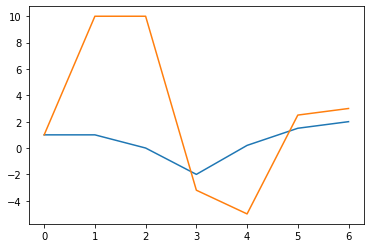

In [ ]:
x = [0,1,2,3,4,5,6]
y = [1 + 1j, 1 + 10j, 0. + 10j, -2 - 3.2j, 0.2 - 5j, 1.5 + 2.5j, 2 + 3j]

print(jnp.real(jnp.asarray(y)))
print(jnp.imag(jnp.asarray(y)))

plt.clf()
plt.plot(x,y)
plt.plot(x,jnp.imag(jnp.asarray(y)))
plt.show()

In [ ]:
# Transmission check
def tau (eps, params):
    # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_L, eps_R, omega)
    # fetching parameters
    eps_L = params[6]
    eps_R = params[7]
    omega = params[8]
    gamma_L = params[2]
    gamma_R = params[3]

    # Building-up the Hamiltonian
    H  = jnp.zeros((2,2))
    H = H.at[0,0].set(eps_L)
    H = H.at[1,1].set(eps_R)
    H = H.at[0,1].set(omega)
    H = H.at[1,0].set(omega)

    # Gamma matrices
    gaL = jnp.zeros((2,2))
    gaL = gaL.at[0,0].set(gamma_L)

    gaR = jnp.zeros((2,2))
    gaR = gaR.at[1,1].set(gamma_R)

    # Green's functions
    G_params_r = [H, gaL, gaR, "r"] # retarded
    green_r = green(eps, G_params_r)

    G_params_a = [H, gaL, gaR, "a"] # advanced
    green_a = green(eps, G_params_a)

    # Terms
    terms_L = jnp.matmul(gaL, green_r)
    terms_R = jnp.matmul(gaR, green_a)

    temp = jnp.matmul(terms_L, terms_R) 
    res = jnp.trace(temp)

    return res

v_tau = vmap(tau,(0,None))

In [ ]:
et_axis = jnp.linspace(-100,100,20001)
my_tau_params = [0.01,
                 0.,
                 5.,
                 5.,
                 1.01,
                 1.0,
                 0.,
                 0.,
                 10] # (mu_L, mu_R, gamma_L, gamma_R, beta_L, beta_R, eps_L, eps_R, omega)
tau_out = v_tau(et_axis, my_tau_params) 
print(tau_out.shape)

(20001,)


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


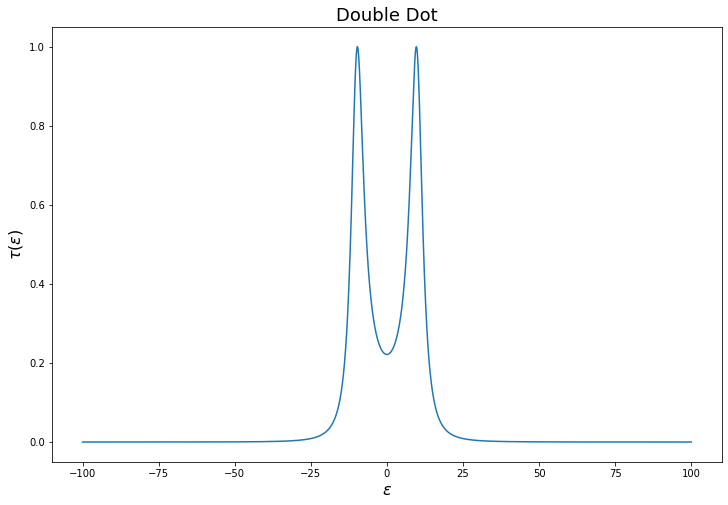

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(et_axis,tau_out)
ax.set_title("Double Dot",fontsize=18)
ax.set_ylabel(r'$\tau (\epsilon)$',fontsize=16)
ax.set_xlabel(r'$\epsilon$',fontsize=16)
# plt.savefig("Lorentzian_DD.png",dpi=500)
plt.show()